Ring Attractor
==============



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../../')

import torch
import gc
import pandas as pd
from time import perf_counter

from src.network import Network
from src.decode import decode_bump
from src.utils import clear_cache

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Parameters



In [1]:
REPO_ROOT = '/home/leon/models/NeuroTorch/'
conf_name = 'config_ringEI.yml'

## Exploring Parameter Space



To find parameters for which we have a multistable ring attractor, we use torch **batching** capabilities to run parallel simulations across the parameter space. The idea is that we will create "batches" of parameters and pass them to the model.



### Batching a single parameter



In [1]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, DT=0.001, VERBOSE=0, LIVE_FF_UPDATE=1, I0=[1, 0])

With torch we can easily pass lists of parameters or batches to the model.
Here, let's batch the recurrent strenght $J_{EE}$.



In [1]:
N_BATCH = 20
# Here we pass a list of parameters to J_STP which is JEE for the model with stp
model.J_STP = torch.linspace(0, 20, N_BATCH, dtype=torch.float32, device='cuda')

# For consistency we need to add a dummy extra dimension
# This is so that the models performs dot products correctly
# In the model J_STP is multiplied by rates of size (N_BATCH * N_NEURON)
# (N_BATCH * 1) * (N_BATCH * N_NEURON) = (N_BATCH * N_NEURON)

model.J_STP = model.J_STP.unsqueeze(-1)

# We set the number of batches
model.N_BATCH = N_BATCH
# and run the model

rates_Jee = model(RET_STP=1).cpu().detach().numpy()

In [1]:
m0, m1, phi = decode_bump(rates_Jee, axis=-1)
print(m0.shape)

(20, 21)

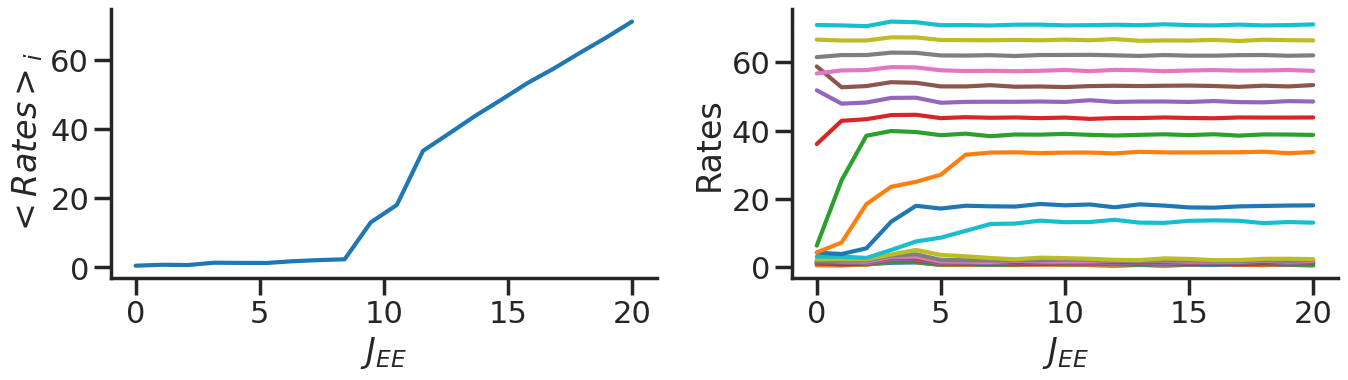

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_Jee[:,-1].mean(-1)

ax[0].plot(model.J_STP.cpu(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$<Rates>_i$')

ax[1].plot(rates_Jee.mean(-1).T)
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('Rates')
plt.show()

In [1]:
print(model.J_STP.shape, m1.shape)

torch.Size([20, 1]) (20, 21)

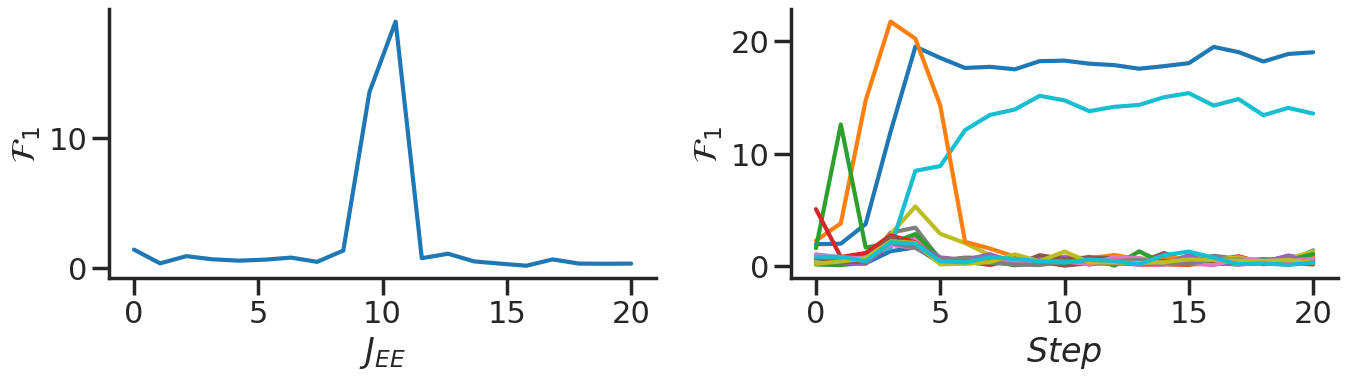

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(model.J_STP.cpu(), m1[:, -1])
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$\mathcal{F}_1$')

ax[1].plot(m1.T)
ax[1].set_xlabel('$Step$')
ax[1].set_ylabel('$\mathcal{F}_1$')
plt.show()

Here, for example, with J<sub>STP</sub>=10 we have a ring attractor!



### Batching multiple parameters



Sometimes we won't be so lucky and need to search harder over multiple parameters.
In order to **batch** over multiple parameters, we need to carefully create each parameter batch. 
Here, let's batch the recurrent strenght $J_{EE}$ and the feedforward strength $J_{E0}$.



In [1]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, DT=0.001, VERBOSE=0, LIVE_FF_UPDATE=1, N_BATCH=1, I0=[1, 0])

First we create the lists of parameters to sweep



In [1]:
N_JEE = 20
N_JE0 = 10

JEE_list = torch.linspace(5, 10, N_JEE, device='cuda')
print('Jee list', JEE_list)
JE0_list = torch.linspace(0, 10, N_JE0, device='cuda')
print('Je0 list', JE0_list)

Jee list tensor([ 5.0000,  5.2632,  5.5263,  5.7895,  6.0526,  6.3158,  6.5789,  6.8421,
         7.1053,  7.3684,  7.6316,  7.8947,  8.1579,  8.4211,  8.6842,  8.9474,
         9.2105,  9.4737,  9.7368, 10.0000], device='cuda:0')
Je0 list tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000], device='cuda:0')

Now we need to expand these lists into tensors with the correct shapes.
To do so we create a two new tensors J<sub>EE</sub> and J<sub>E0</sub> of size (N<sub>JEE</sub>, N<sub>JE0</sub>)
where each row of J<sub>EE</sub> is a repetition of Jee list and each column of Je0 is a copy of Je0 list.
In that way, all the values of J<sub>EE</sub> are associated once with a value of Je0.



In [1]:
JEE = JEE_list.unsqueeze(0).expand(N_JE0, N_JEE)
print('JEE first col', JEE[:, 0])

JE0 = JE0_list.unsqueeze(1).expand(N_JE0, N_JEE)
print('JE0 first row', JE0[0])

JEE first col tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:0')
JE0 first row tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

Torch models need a single batch dimension so we concatenate the two dimensions into tensors of size (N<sub>BATCH</sub>=N<sub>JEE</sub>\*N<sub>JE0</sub>, 1)
We need the extra dummy dimension so that in the model dot products are done properly.



In [1]:
JEE = JEE.reshape((-1, 1)) 
print('JEE', JEE.shape)

JE0 = JE0.reshape((-1, 1)) * model.M0  # Here M0 is a scaling factor that we have to add
print('JE0', JE0.shape)

JEE torch.Size([200, 1])
JE0 torch.Size([200, 1])

Now we need to set the number of batches and copy our tensors to the model



In [1]:
N_BATCH = N_JE0 * N_JEE
# Here we need to do some work on Ja0 first,
# since it has two dimensions for E and I and we need to repeat the I values
Ja0 = model.Ja0.repeat((N_BATCH, 1, 1))
print('Ja0', Ja0.shape)

# now we can pass JE0 to Ja0
Ja0[:,0] = JE0

# and pass N_BATCH, Ja0 and Jee to the model
model.N_BATCH = N_BATCH
# copy Ja0
model.Ja0 = Ja0
# in the model with stp, JEE is J_STP
model.J_STP = JEE

Ja0 torch.Size([200, 2, 1])

Let's run the simulations



In [1]:
start = perf_counter()
rates = model().cpu().detach().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 11s
rates (200, 21, 500)

Let's compute the fourier moments of the population activity and reshape them



In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)

m0 = m0.reshape(N_JE0, N_JEE, -1)
m1 = m1.reshape(N_JE0, N_JEE, -1)

In [1]:
JEE = np.linspace(5, 10, N_JEE)
JE0 = np.linspace(0, 10, N_JE0)

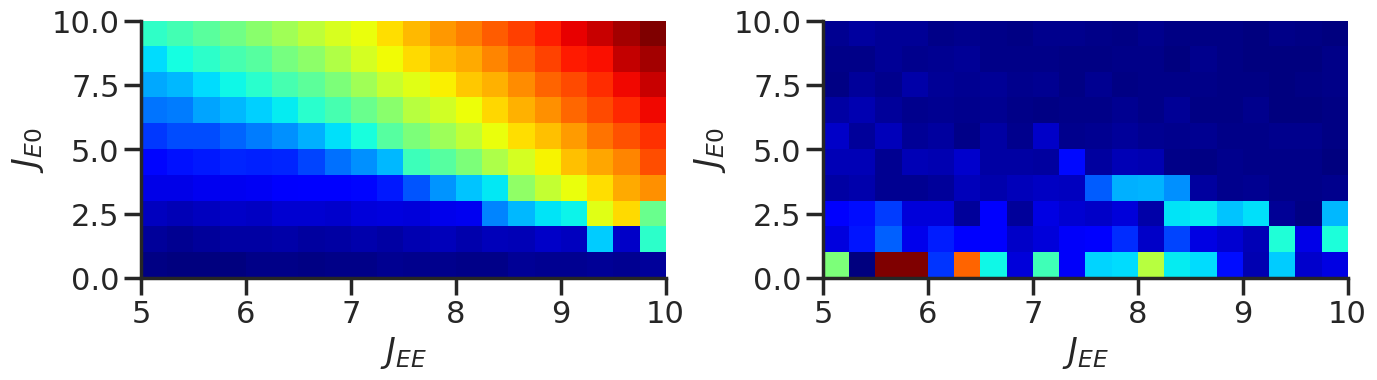

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(m0[..., -1], cmap='jet', origin='lower', vmin=0, aspect='auto', extent=[JEE[0], JEE[-1], JE0[0], JE0[-1]])
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$J_{E0}$')

ax[1].imshow(m1[...,-1]/m0[...,-1], cmap='jet', origin='lower', vmin=0, vmax=3, aspect='auto', extent=[JEE[0], JEE[-1], JE0[0], JE0[-1]])
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('$J_{E0}$')

plt.show()

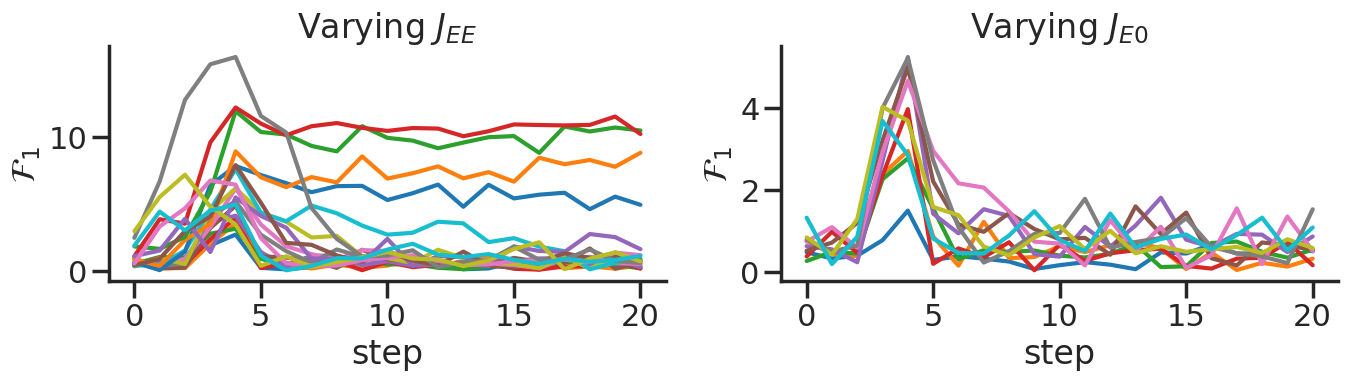

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(m1[3].T)
ax[0].set_ylabel('$\mathcal{F}_1$')
ax[0].set_xlabel('step')
ax[0].set_title('Varying $J_{EE}$')

ax[1].plot(m1[:, 3].T)
ax[1].set_ylabel('$\mathcal{F}_1$')
ax[1].set_xlabel('step')
ax[1].set_title('Varying $J_{E0}$')

plt.show()

The parameters corresponding to (row 3, col -1) work!

We can get their values from their matrix form



In [1]:
JEE = torch.linspace(5, 10, N_JEE, device='cuda')
JE0 = torch.linspace(0, 10, N_JE0, device='cuda')

JEE = JEE.unsqueeze(0).expand(N_JE0, N_JEE)
JE0 = JE0.unsqueeze(1).expand(N_JE0, N_JEE)

print('JE0', JE0[3, -1].item())
print('JEE', JEE[3, -1].item())

JE0 3.3333334922790527
JEE 10.0

or directly from the original lists



In [1]:
JE0 = torch.linspace(0, 10, N_JE0, device='cuda')
print('JE0', JE0[3].item())

JEE = torch.linspace(5, 10, N_JEE, device='cuda')
print('JEE', JEE[-1].item())

JE0 3.3333334922790527
JEE 10.0

Let's test them.



In [1]:
model = Network(conf_name, REPO_ROOT, TASK='odr',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=1, LIVE_FF_UPDATE=1)

model.Ja0[:, 0] = JE0[3] 
model.J_STP = JEE[-1]

In [1]:
rates = model().cpu().numpy()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print('m0', m0.shape)

m0 (1, 21)

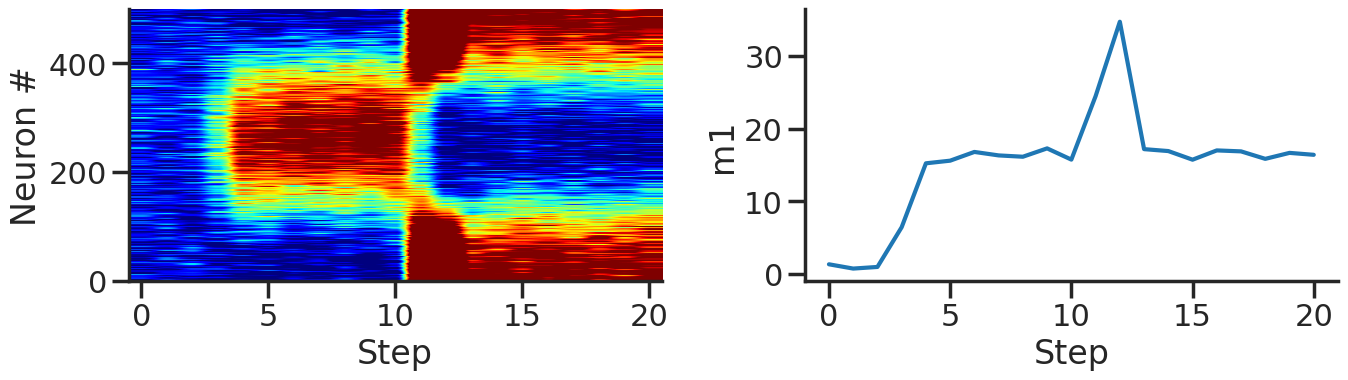

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

r_max = 30

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Neuron #')
ax[0].set_xlabel('Step')

ax[1].plot(m1.T)
ax[1].set_ylabel('m1')
ax[1].set_xlabel('Step')

plt.show()

## Serial bias



Now that we have found a ring attractor we can investigate the biases in the model



In [1]:
model = Network(conf_name, REPO_ROOT, TASK='odr',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=1, LIVE_FF_UPDATE=1)

### Simulations



In [1]:
N_PHASE = 1024
print(model.PHI0.shape)

PHI0 = model.PHI0.unsqueeze(-1).repeat((N_PHASE, 1, 1))

print(PHI0.shape)
PHI0[:, -1] = torch.randint(0, 360, (N_PHASE,), device=model.device).unsqueeze(1)
PHI0[:, 0] = torch.randint(0, 360, (N_PHASE,), device=model.device).unsqueeze(1)

torch.Size([1, 2])
torch.Size([1024, 2, 1])

In [1]:
model.PHI0 = PHI0
model.N_BATCH = N_PHASE
rates = model().cpu().numpy()
print(rates.shape)

(1024, 21, 500)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(1024, 21)

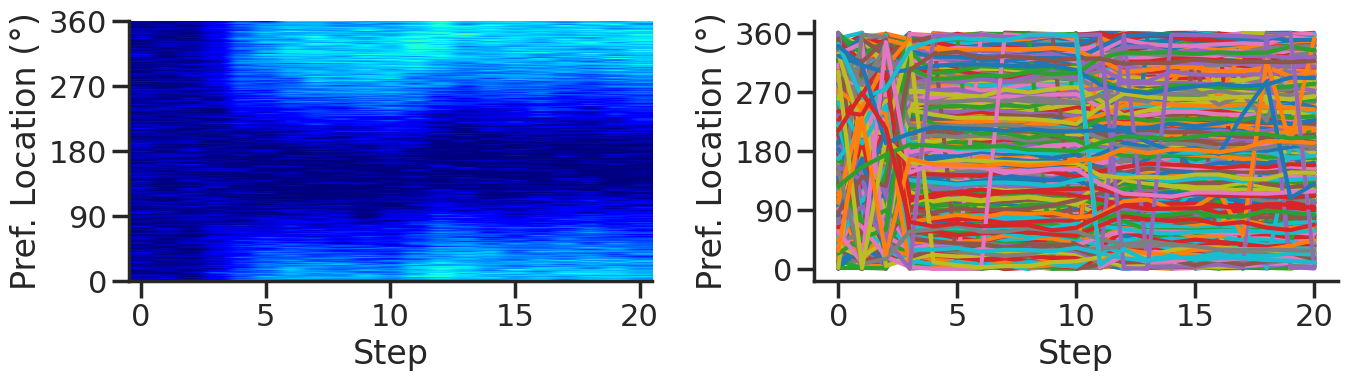

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
r_max = np.max(rates[0]) *2

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi.T * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [1]:
target_loc = model.PHI0[:, -1].cpu().numpy()
rel_loc = model.PHI0[:, 0].cpu().numpy() - target_loc
rel_loc = (rel_loc / 180 * np.pi + np.pi) % (2*np.pi) - np.pi
errors = phi - target_loc * np.pi / 180.0
errors = (errors + np.pi) % (2*np.pi) - np.pi

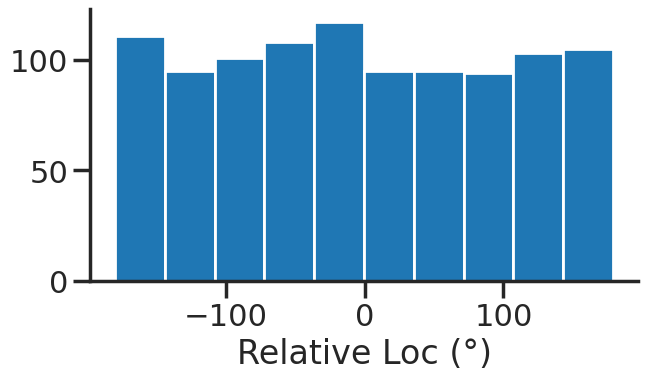

In [1]:
plt.hist(rel_loc * 180 / np.pi)
plt.xlabel('Relative Loc (°)')
plt.show()

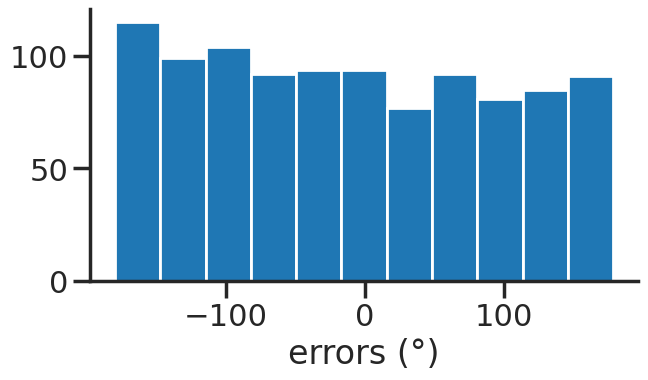

In [1]:
plt.hist(errors[:, -1] * 180/np.pi, bins='auto')
plt.xlabel('errors (°)')
plt.show()

### Systematic biases



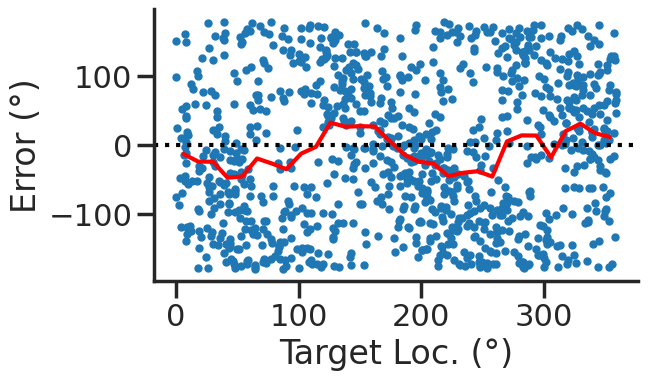

In [1]:
plt.plot(target_loc[:, 0], errors[:,-1] * 180 / np.pi, 'o')
plt.xlabel('Target Loc. (°)')
plt.ylabel('Error (°)')

from scipy.stats import binned_statistic
stt = binned_statistic(target_loc[:,0], errors[:,-1] * 180/np.pi, statistic='mean', bins=30, range=[0, 360])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")
plt.show()

### Serial biases



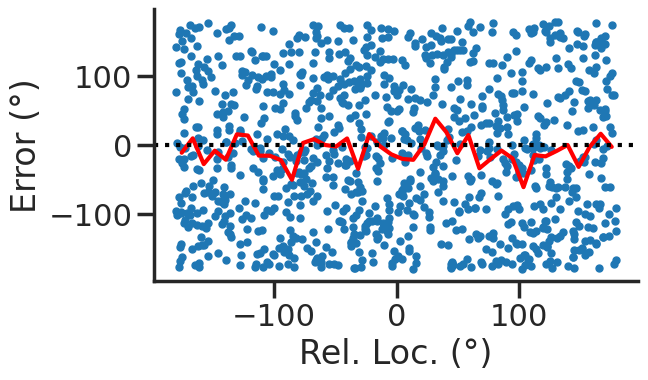

In [1]:
plt.plot(rel_loc[:, 0] * 180 / np.pi, errors[:,-1] * 180 / np.pi, 'o')
plt.xlabel('Rel. Loc. (°)')
plt.ylabel('Error (°)')
#plt.ylim([-60, 60])

from scipy.stats import binned_statistic
stt = binned_statistic(rel_loc[:,0]*180/np.pi, errors[:,-1]*180/np.pi, statistic='mean', bins=40, range=[-180, 180])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")
plt.show()